## 2D Spectra 

This notebook expands the analysis of the vertical and horizontal spectra, estimating the 2D spectra of along isopycnal tracers. 

We do the analysis in isopycnal space for the horizontal, and use the mean depth of the isopycnal as the vertical coordinate. 

This has a few things:
- removes IW signals for tracers. If we did horizontal vs Z, we would just end up seeing the properties of the IWs (which are highly aliased). 
- Flattening isopycnals for the mesoscale is a bit in line with QG theory, plus it is unlikely that this makes much of a difference to the signal we are thinking about here. 


In [1]:
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import xrft 

import gsw

In [2]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [3]:
ds_660_rho = xr.open_dataset('data/sg_O2_660_isopycnal_grid_4m_27_sept_2021.nc')


In [4]:
# compute spice 
# Pick constant alpha and beta for convenience (can always update later)
alpha = 8e-5
beta  = 77.4e-5

# remove a mean per isopycnal
dCT = ds_660_rho.CT  - ds_660_rho.CT.mean('dives')
dSA = ds_660_rho.SA - ds_660_rho.SA.mean('dives')

ds_660_rho['Spice'] = (alpha*dCT + beta*dSA).rename('Spice')

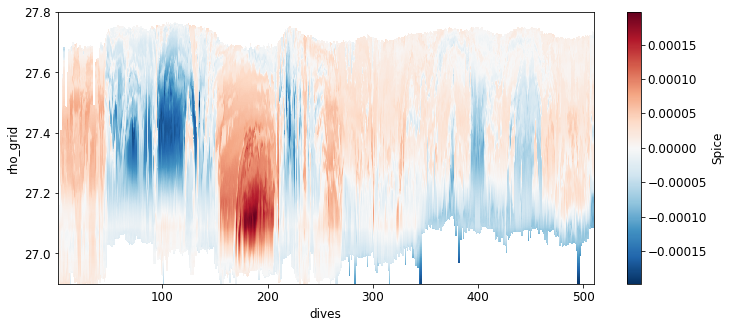

In [6]:
plt.figure(figsize=(12, 5))
ds_660_rho.Spice.plot()

In [8]:
ds_660_grid = xr.open_dataset('data/sg_660_vert_4m_binned_geoff_cleaned_adjusted_27_sept_2021.nc')
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

When computing the spectra in vertical coordinate we did rescaling of the vertical coordinate from Z to Z_tilde, where the rescaling when like N/f. This was based on Smith and Ferrari 09, which showed that the spectra are isotropic in this rescaled space. So essentially we were trying to use the vertical spectra to guess the horizontal spectra, assuming that the QG scaling holds. 
Here instead when we estimate the 2D spectra directly, we try to estimate what is actually going on rather than trying to use the QG hypothesis. The result can then be checked for isotropy etc. 


In [23]:
# First consider the frequency spectrum

In [21]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(121, 205, 1/24)

   
    for i in range(len(ds.rho_grid)):
        ds_temp =ds.isel(rho_grid=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var], bounds_error=False)
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "rho_grid": ds_temp.rho_grid}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='rho_grid')
        
    return da_var_int

In [22]:
ds_660_time = xr.merge([interp_time(ds_660_rho,'ctd_pressure'),
                        interp_time(ds_660_rho,'Spice'),
                        interp_time(ds_660_rho,'CT'),
                        interp_time(ds_660_rho,'SA')])

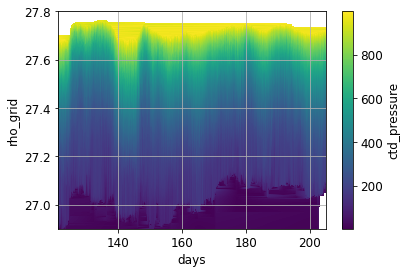

In [24]:
ds_660_time.ctd_pressure.plot()
plt.grid()
# One of the annoying things about the gridding at the moment is that it fills in places 
# where there is no data. This could potentially be resolved by using some sort of mask,
# but for now just ignore those regions.

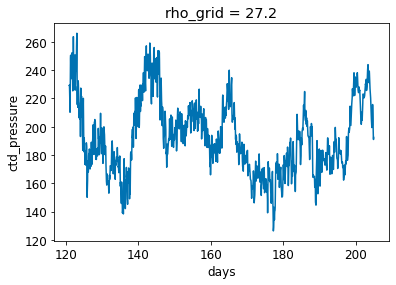

In [25]:
ds_660_time.ctd_pressure.sel(rho_grid=27.2, method='nearest').plot()

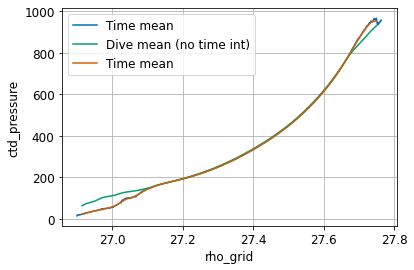

In [28]:
Pmean_smooth_dives = ds_660_rho.ctd_pressure.mean('dives').rolling(rho_grid= 30, center=True).mean()
Pmean_smooth_time = ds_660_time.ctd_pressure.mean('days').rolling(rho_grid= 30, center=True).mean()
# the smoothing using rolling is done to remove any overturns in the mean

ds_660_time.ctd_pressure.mean('days').plot(label='Time mean')
Pmean_smooth_dives.plot(label='Dive mean (no time int)')
Pmean_smooth_time.plot(label = 'Time mean')
plt.grid()

plt.legend()

In [33]:
# Function that regrids a single dive 
# Will be rung in a loop to do interpolation for all dives.

def func_var_int_pmean(ds): 
    Pmean_grid = np.linspace(0,1000,501)
    
    Pmean = Pmean_smooth_time
 
    ds_nonan = ds.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    Pmean_nonan = Pmean.where(~np.isnan(ds) & ~np.isnan(Pmean), drop=True)
    
    if len(ds_nonan) > 2:
        f = interpolate.PchipInterpolator(Pmean_nonan.values, ds_nonan.values , extrapolate=False)
        ds_on_Pmean = f(Pmean_grid)
    else:
        ds_on_Pmean = np.nan*Pmean_grid
    
    return xr.DataArray(ds_on_Pmean.reshape((-1,1)),
                        dims = ['Pmean', 'days'],
                        coords = {'Pmean': Pmean_grid, 'days': [ds.days.values]})
    

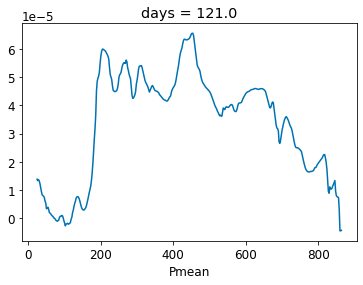

In [37]:
time_ind = 0
spice_on_Pmean = func_var_int_pmean(ds_660_time.Spice.isel(days=0))

for time_ind in range(1, len(ds_660_time.days)):
    if np.mod(time_ind, 400)==0:
        print(time_ind)
    spice_on_Pmean = xr.concat([spice_on_Pmean, 
                                func_var_int_pmean(ds_660_time.Spice.isel(days=time_ind))],
                                dim='days')

400
800
1200
1600
2000


(800.0, 180.0)

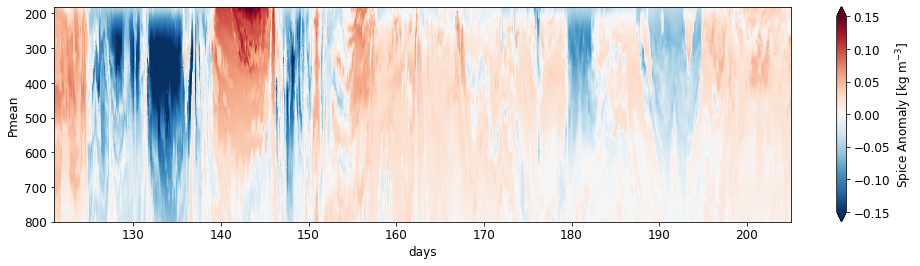

In [42]:
plt.figure(figsize=(2.2*7.5,2.2*1.8))
(1000*spice_on_Pmean).plot(vmin=-1.5e-1, rasterized=True, #interpolation= None,
                           cbar_kwargs={'label': 'Spice Anomaly [kg m$^{-3}$]'})
plt.gca().invert_yaxis()

plt.ylim([800, 180]) # this is the range that is not super influenced by interplation.

In [43]:
# Now we have the section that we will use to do the spectral calc on.

In [45]:
spice_on_Pmean.sel(Pmean=slice(180, 800))

<xarray.DataArray (Pmean: 311, days: 2016)>
array([[ 2.36459560e-05,  2.51984430e-05,  3.12112769e-05, ...,
        -3.91346713e-07,  4.90173729e-07,  1.63970587e-06],
       [ 2.79130924e-05,  2.88625497e-05,  3.40508288e-05, ...,
         1.45735087e-06,  3.00687887e-06,  4.13191378e-06],
       [ 3.17636475e-05,  3.18163095e-05,  3.58411279e-05, ...,
         3.19629467e-06,  5.22020110e-06,  6.35064260e-06],
       ...,
       [ 1.86295929e-05,  2.13738796e-05,  2.41243781e-05, ...,
         1.17727410e-05,  1.19008300e-05,  1.20233315e-05],
       [ 1.91117890e-05,  2.17709095e-05,  2.44285158e-05, ...,
         1.20281793e-05,  1.22417775e-05,  1.24549766e-05],
       [ 1.94891970e-05,  2.21120742e-05,  2.47347193e-05, ...,
         1.22124854e-05,  1.25411479e-05,  1.28681477e-05]])
Coordinates:
  * Pmean    (Pmean) float64 180.0 182.0 184.0 186.0 ... 794.0 796.0 798.0 800.0
  * days     (days) float64 121.0 121.0 121.1 121.1 ... 204.8 204.9 204.9 205.0

In [46]:
import xrft

In [105]:
spice_on_Pmean.sel(Pmean=slice(180, 800),).chunk({'days':500})

<xarray.DataArray (Pmean: 311, days: 2016)>
dask.array<xarray-<this-array>, shape=(311, 2016), dtype=float64, chunksize=(311, 500), chunktype=numpy.ndarray>
Coordinates:
  * Pmean    (Pmean) float64 180.0 182.0 184.0 186.0 ... 794.0 796.0 798.0 800.0
  * days     (days) float64 121.0 121.0 121.1 121.1 ... 204.8 204.9 204.9 205.0

In [135]:
spice_2d_ps =xrft.power_spectrum(spice_on_Pmean.sel(Pmean=slice(180, 800)).isel(days=slice(0,2000)).chunk({'days':400}), dim=['Pmean', 'days'],
                                window=True, chunks_to_segments=True)

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [136]:
spice_2d_ps

<xarray.DataArray 'rechunk-merge-2e3cd6dc7a8a30b40a66d281e79e00e3' (Pmean_segment: 1, freq_Pmean: 311, days_segment: 5, freq_days: 400)>
dask.array<mul, shape=(1, 311, 5, 400), dtype=float64, chunksize=(1, 311, 1, 400), chunktype=numpy.ndarray>
Coordinates:
  * Pmean_segment  (Pmean_segment) int64 0
  * days_segment   (days_segment) int64 0 1 2 3 4
  * freq_Pmean     (freq_Pmean) float64 -0.2492 -0.2476 -0.246 ... 0.2476 0.2492
  * freq_days      (freq_days) float64 -12.0 -11.94 -11.88 ... 11.82 11.88 11.94

(0.0016129032258064516, 0.25)

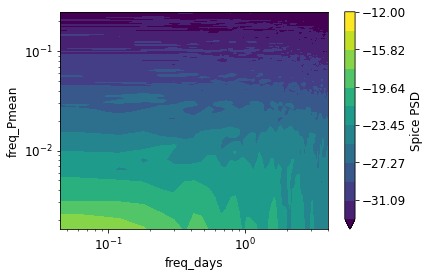

In [137]:
np.log(spice_2d_ps.mean(['Pmean_segment', 'days_segment'])
      ).plot.contourf(levels=np.linspace(-33,-12, 12),
                     cbar_kwargs={'label':'Spice PSD'})
plt.xscale('log')
plt.xlim([4/90, 24/6])
plt.yscale('log')
plt.ylim([1/620, 1/4])
#plt.grid()

Text(0.5, 1.0, 'Variance Preserving PSD')

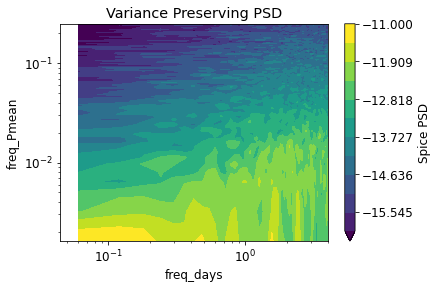

In [138]:
m = spice_2d_ps.freq_Pmean
k = spice_2d_ps.freq_days

np.log10(np.abs(m)*np.abs(k)*spice_2d_ps.mean(['Pmean_segment', 'days_segment'])
      ).plot.contourf(levels=np.linspace(-16,-11, 12),
                     cbar_kwargs={'label':'Spice PSD'})
plt.xscale('log')
plt.xlim([4/90, 24/6])
plt.yscale('log')
plt.ylim([1/620, 1/4])
#plt.grid()
plt.title('Variance Preserving PSD')

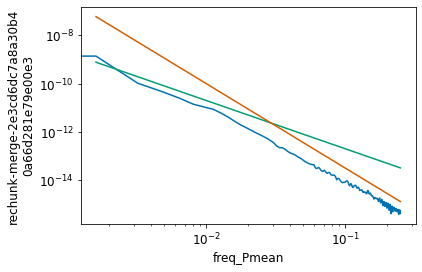

In [139]:
m = spice_2d_ps.freq_Pmean
spice_2d_ps.mean(['Pmean_segment', 'days_segment']).mean('freq_days').plot()

plt.plot(m, 2e-15*m**-2)
plt.plot(m, 1e-17*m**-3.5)

plt.xscale('log')
#plt.xlim([1e-2, 10])
plt.yscale('log')
#plt.ylim([1e-3, 4/24])

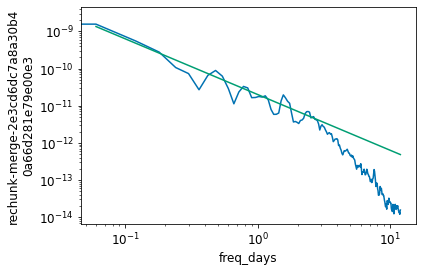

In [140]:
k = spice_2d_ps.freq_days
spice_2d_ps.mean(['Pmean_segment', 'days_segment']).mean('freq_Pmean').plot()

plt.plot(k, 2e-11*k**-1.5)
#plt.plot(m, 2e-17*m**-3)

plt.xscale('log')
#plt.xlim([1e-2, 10])
plt.yscale('log')
#plt.ylim([1e-3, 4/24])